# Modeling

## Pipeline Template and Dataset Splitting

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer


In [2]:
df = pd.read_csv("../data/raw/churn_ibm.csv")

In [ ]:

# ==========================================
# 1. Charge and initial Cleaning
# ==========================================
# df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv') # Descomentar para cargar

# Definimos las columnas a eliminar (Blacklist del EDA)
DROP_COLS = [
    'EmployeeCount', 'Over18', 'StandardHours',  # Constant
    'EmployeeNumber',                            # IDs
    'DailyRate', 'HourlyRate', 'MonthlyRate',    # Noise
    'PerformanceRating', 'PercentSalaryHike'     # Low Variance
    'TotalWorkingYears', 'YearsInCurrentRole'
]

df_clean = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors='ignore')

# ==========================================
# 2. FEATURE ENGINEERING
# ==========================================

# A. Satisfaction Index: Suma de todas las satisfacciones (dará un valor de 4 a 16)
df_clean['TotalSatisfaction'] = (
    df_clean['EnvironmentSatisfaction'] + 
    df_clean['JobSatisfaction'] + 
    df_clean['RelationshipSatisfaction'] + 
    df_clean['JobInvolvement']
)

# B. Log Transform manual (correct bias in Income and Distance)
# We use log1p to avoid log(0)
df_clean['Log_MonthlyIncome'] = np.log1p(df_clean['MonthlyIncome'])
df_clean['Log_DistanceFromHome'] = np.log1p(df_clean['DistanceFromHome'])

# Drop original ones
df_clean.drop(columns=['MonthlyIncome', 'DistanceFromHome'], inplace=True)

print("✅ Feature Engineering completed.")

# ==========================================
# 3. Correct types
# ==========================================

TARGET = 'Attrition'

NUMERIC_FEATURES = [
    # --- Continuous ---
    'Age',
    'Log_DistanceFromHome',          # Candidate to Log-Transform
    'Log_MonthlyIncome',             # Candidate to Log-Transform
    'YearsAtCompany',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager',
    'NumCompaniesWorked',
    'TrainingTimesLastYear',

    # --- Ordinals (1-4) treated as Numeric ---
    # We treat then as numbers because the order (4 > 1) matters matematically
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',            # Very important!
    'JobLevel',
    'JobSatisfaction',
    'RelationshipSatisfaction',
    'WorkLifeBalance'
]

CATEGORICAL_FEATURES = [
    'BusinessTravel',       # Non-Travel, Travel_Rarely, etc.
    'Department',           # Sales, R&D, HR
    'EducationField',       # Marketing, Life Sciences, etc.
    'JobRole',              # Sales Rep, Manager, etc. (Very important!)
    'MaritalStatus',        # Single, Married, Divorced (Very important!)
    'OverTime',             # Yes/No (Predictor #1)
    
    # --- Special Case ---
    'StockOptionLevel'      # (0, 1, 2, 3)
    # OBSERVATION: this variable will be treated better by the model as
    # categorical, because of the U relationship with the target
]

# Type correction
for col in CATEGORICAL_FEATURES:
    df_clean[col] = df_clean[col].astype(str)

# ==========================================
# 4. SPLIT X (Features) / y (Target)
# ==========================================
X = df_clean[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = df_clean[TARGET].map({'Yes': 1, 'No': 0}) # Encoding of Target

# ==========================================
# 5. TRAIN-TEST SPLIT
# ==========================================
# stratify=y for maintain proportion of churners
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Shapes -> X_train: {X_train.shape}, X_test: {X_test.shape}")

# ==========================================
# 6. PIPELINES
# ==========================================

# A. Numeric Pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# B. Categorical Pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ==========================================
# 7. PREPROCESSOR (COLUMN TRANSFORMER)
# ==========================================
# Unimos todo en un solo objeto transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    verbose_feature_names_out=False # Clean names
)


# Try that it works
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert into df
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)

print("\nData Preparation Pipeline Done.")
print(f"Final variables after Encoding: {X_train_df.shape[1]}")
display(X_train_df.head())

✅ Feature Engineering completed.
Shapes -> X_train: (1176, 22), X_test: (294, 22)

Data Preparation Pipeline Done.
Final variables after Encoding: 45


,Age,Log_DistanceFromHome,Log_MonthlyIncome,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,NumCompaniesWorked,TrainingTimesLastYear,Education,EnvironmentSatisfaction,...,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3
1194,1.090194,-1.046437,1.690981,-0.665706,-0.368024,-0.616406,1.330763,-0.605389,1.064209,-0.658710,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
128,-1.634828,-1.046437,-1.108058,-0.830071,-0.056884,-0.897047,-1.083704,-0.605389,-1.855332,0.260202,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
810,0.981193,-0.711628,1.826538,0.813578,0.565398,1.348076,0.123529,0.190962,-1.855332,-1.577622,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
478,-1.307825,0.746362,-1.389224,-0.008246,-0.679165,0.506155,-0.681293,-1.401740,-1.855332,-0.658710,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
491,0.654191,0.354769,0.122430,0.156119,0.565398,0.786795,0.123529,0.190962,2.037390,1.179114,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Modeling Techniques Candidates

In this case, we are going to use, because of the interpretability these models can give us, and in order to show the user the feature importance of the parameters:

* Logistic Regression

* Random Forest

* XGBoost

Ratio for XGBoost : 5.19
🚀 Starting Cold Start Tuning...

✅ Logistic Regression trained. AUC: 0.814 | Recall: 0.617
✅ Random Forest trained. AUC: 0.772 | Recall: 0.128
✅ XGBoost trained. AUC: 0.779 | Recall: 0.340


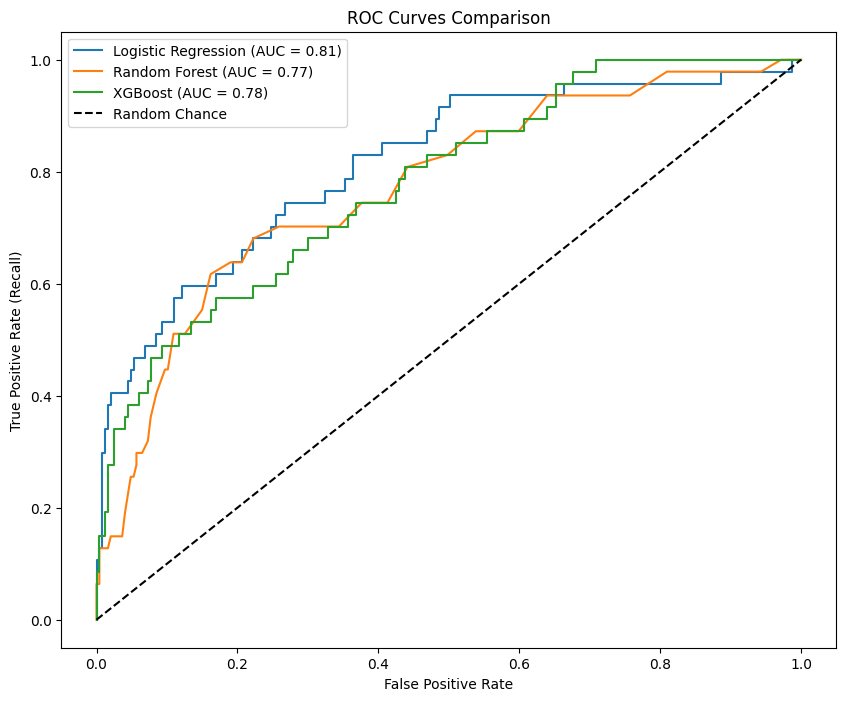


🏆 RESULTS TABLE (Ordered by Recall):


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
Logistic Regression,0.778912,0.381579,0.617021,0.471545,0.814282
XGBoost,0.863946,0.640000,0.340426,0.444444,0.779481
Random Forest,0.857143,0.857143,0.127660,0.222222,0.772116


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# ==========================================
# 0. IMBALANCE HANDLING
# ==========================================
# Ratio for XGBoost (Negative / Positive)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Ratio for XGBoost : {scale_pos_weight:.2f}")

# ==========================================
# 1. MODEL DEFINITION
# ==========================================
# We use class_weight='balanced' to make the model give importance to the minority
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', 
        random_state=42, 
        max_iter=1000
    ),
    
    "Random Forest": RandomForestClassifier(
        class_weight='balanced', 
        n_estimators=100,      # 100 Trees
        random_state=42,
        n_jobs=-1              
    ),
    
    "XGBoost": XGBClassifier(
        scale_pos_weight=scale_pos_weight, # class_weight in XGBoost
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
}

# ==========================================
# 2. "COLD" EVALUATION
# ==========================================
results = []

plt.figure(figsize=(10, 8))

print("🚀 Starting Cold Start Tuning...\n")

for name, model in models.items():
    
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    # A. Train
    pipeline.fit(X_train, y_train)
    
    # B. Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # C. Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Guardamos resultados
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,   # ¡Ojo aquí! Lo más importante para Attrition
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    })
    
    # D. Plot ROC Curve (compare visually)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    print(f"✅ {name} trained. AUC: {roc_auc:.3f} | Recall: {recall:.3f}")

# ==========================================
# 3. RESULTS VISUALIZATION
# ==========================================
# Fincal settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title("ROC Curves Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.show()

# Comparable Table
results_df = pd.DataFrame(results).set_index("Model")
results_df = results_df.sort_values(by="Recall", ascending=False)

print("\n🏆 RESULTS TABLE (Ordered by Recall):")
display(results_df.style.background_gradient(cmap="Blues"))

As we can see, only Random Forest demonstrates a pretty low Recall Metric. We will not Fine-Tune this model because of 100 people that leaves our company, it is only able to detect 12!

* Logistic Regression is our "Baseline".

* XGBoost is the model we have to fine tune the most, but 

## Model Validation ("Fine-Tuning")

In [10]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score, precision_recall_curve
from scipy.stats import uniform, randint, loguniform

### Logistic Regression

In [21]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

print("🔇 Silent Warnings. Training model...\n")

# ===== 1. LOGISTIC REGRESSION VALIDATION =====

# 1. Define the Logistic Regression base model
# solver='saga' is robust and supports all penalties (l1, l2, elasticnet)
lr_classifier = LogisticRegression(
    class_weight='balanced',
    solver='saga', 
    max_iter=5000, # Increased to ensure convergence
    random_state=42,
    n_jobs=-1
)

# 2. Define the specific pipeline
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", lr_classifier)
])

# 3. Define the Values we will try to "fine tune"
# Note: We use distributions (loguniform) for 'C' to cover a wider range efficiently
lr_params = {
    'classifier__C': loguniform(1e-4, 100),       # Inverse of regularization strength
    'classifier__penalty': ['l1', 'l2', 'elasticnet'], 
    'classifier__l1_ratio': uniform(0, 1),         # Only used if penalty='elasticnet'
    'classifier__class_weight': ['balanced',       # Auto-balance based on frequencies
                     {0: 1, 1: 3},     # Manual: Churners are 3x more important
                     {0: 1, 1: 5}]
}

# 4. Configure RandomizedSearchCV
print("Training Logistic Regression...")
lr_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=lr_params,
    n_iter=50,
    scoring="f1", # Optimizing F1 helps balance Precision/Recall
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

lr_search.fit(X_train, y_train)

# 5. Evaluation and Business Metrics
best_lr = lr_search.best_estimator_
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

# -- Threshold Optimization --
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_prob_lr)
f1_scores_lr = 2 * (precision_lr * recall_lr) / (precision_lr + recall_lr)
f1_scores_lr = np.nan_to_num(f1_scores_lr) 
best_idx_lr = np.argmax(f1_scores_lr)
best_thresh_lr = thresholds_lr[best_idx_lr]
best_f1_lr = f1_scores_lr[best_idx_lr]

# -- Capture Rate Top 10% --
results_df_lr = pd.DataFrame({'actual': y_test, 'prob': y_prob_lr})
results_df_lr = results_df_lr.sort_values(by='prob', ascending=False)
n_top_10_lr = int(len(results_df_lr) * 0.10)
capture_rate_lr = results_df_lr.head(n_top_10_lr)['actual'].sum() / results_df_lr['actual'].sum()

print(f"Logistic Regression - Best Configurations: {lr_search.best_params_}")
print(f"F1 score optimized: {best_f1_lr:.4f} with threshold {best_thresh_lr:.4f}")
print(f"Top 10% Capture Rate: {capture_rate_lr:.4f}")

🔇 Silent Warnings. Training model...

Training Logistic Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Logistic Regression - Best Configurations: {'classifier__C': np.float64(0.035557829810072855), 'classifier__class_weight': {0: 1, 1: 3}, 'classifier__l1_ratio': np.float64(0.5467102793432796), 'classifier__penalty': 'l2'}
F1 score optimized: 0.5952 with threshold 0.5764
Top 10% Capture Rate: 0.4468


### XGBoost

In [20]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

print("🔇 Silent Warnings. Training model...\n")

# ===== 2. XGBOOST VALIDATION =====

# 0. Calculate scale_pos_weight for imbalance
# Ratio: Negative samples / Positive samples
ratio_imbalance = (y_train == 0).sum() / (y_train == 1).sum()

# 1. Define the XGBoost base model
xgb_classifier = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
    # We don't set scale_pos_weight here fixed, we will tune it around the ratio
)

# 2. Define the specific pipeline
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb_classifier)
])

# 3. Define the Values we will try to "fine tune"
xgb_params = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__learning_rate': uniform(0.01, 0.2), # Lower is often better but slower
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.6, 0.4),      # Prevent overfitting
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    # Critical: We allow the model to explore weights around the calculated ratio
    'classifier__scale_pos_weight': [ratio_imbalance, ratio_imbalance * 1.5, ratio_imbalance * 2] 
}

# 4. Configure RandomizedSearchCV
print("Training XGBoost...")
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_params,
    n_iter=50,
    scoring="f1", # Or 'roc_auc' depending on your preference
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

# 5. Evaluation and Business Metrics
best_xgb = xgb_search.best_estimator_
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

# -- Threshold Optimization --
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_prob_xgb)
f1_scores_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)
f1_scores_xgb = np.nan_to_num(f1_scores_xgb)
best_idx_xgb = np.argmax(f1_scores_xgb)
best_thresh_xgb = thresholds_xgb[best_idx_xgb]
best_f1_xgb = f1_scores_xgb[best_idx_xgb]

# -- Capture Rate Top 10% --
results_df_xgb = pd.DataFrame({'actual': y_test, 'prob': y_prob_xgb})
results_df_xgb = results_df_xgb.sort_values(by='prob', ascending=False)
n_top_10_xgb = int(len(results_df_xgb) * 0.10)
capture_rate_xgb = results_df_xgb.head(n_top_10_xgb)['actual'].sum() / results_df_xgb['actual'].sum()

print(f"XGBoost - Best Configurations: {xgb_search.best_params_}")
print(f"F1 score optimized: {best_f1_xgb:.4f} with threshold {best_thresh_xgb:.4f}")
print(f"Top 10% Capture Rate: {capture_rate_xgb:.4f}")

🔇 Silent Warnings. Training model...

Training XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBoost - Best Configurations: {'classifier__colsample_bytree': np.float64(0.8439986631130484), 'classifier__learning_rate': np.float64(0.17663898234723288), 'classifier__max_depth': 5, 'classifier__n_estimators': 305, 'classifier__scale_pos_weight': np.float64(5.189473684210526), 'classifier__subsample': np.float64(0.7035119926400067)}
F1 score optimized: 0.5124 with threshold 0.0837
Top 10% Capture Rate: 0.3617


## Final Evaluation

In [23]:
# ==============================================================================
# 3. FINAL EVALUATION ON TEST SET
# ==============================================================================
print("\n" + "="*50)
print("🏆 FINAL SHOWDOWN (Test Set Results)")
print("="*50)

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    results = {
        'Model': name,
        'AUC': roc_auc_score(y_test, y_prob),
        'Recall (Sensitivity)': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1 Score': 0  # Placeholder
    }
    # Calculate F1 manually or via function
    from sklearn.metrics import f1_score
    results['F1 Score'] = f1_score(y_test, y_pred)
    
    return results

# Evaluate both "Best" versions
res_lr = evaluate_model(best_lr, X_test, y_test, "Tuned Logistic Regression")
res_xgb = evaluate_model(best_xgb, X_test, y_test, "Tuned XGBoost")

# Create Comparison DataFrame
comparison_df = pd.DataFrame([res_lr, res_xgb]).set_index('Model')

# Display sorted by AUC (or Recall, depending on preference)
display(comparison_df.style.background_gradient(cmap='Blues'))

print("\n🔍 Detailed Report for the Winner (Highest Recall):")
if res_xgb['Recall (Sensitivity)'] > res_lr['Recall (Sensitivity)']:
    print(">> WINNER: XGBoost")
    print(classification_report(y_test, best_xgb.predict(X_test)))
else:
    print(">> WINNER: Logistic Regression")
    print(classification_report(y_test, best_lr.predict(X_test)))


🏆 FINAL SHOWDOWN (Test Set Results)


,AUC,Recall (Sensitivity),Precision,F1 Score
Model,,,,
Tuned Logistic Regression,0.823844,0.574468,0.540000,0.556701
Tuned XGBoost,0.805926,0.361702,0.515152,0.425000



🔍 Detailed Report for the Winner (Highest Recall):
>> WINNER: Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       247
           1       0.54      0.57      0.56        47

    accuracy                           0.85       294
   macro avg       0.73      0.74      0.73       294
weighted avg       0.86      0.85      0.86       294



Looking at the results, we will choose Logistic Regression as the model we will use for our product.

In [28]:
import joblib

# Select the winner pipeline
final_pipeline = lr_search.best_estimator_
filename = '../models/churn_pipeline.joblib'

joblib.dump(final_pipeline, filename)

print(f"✅ Model saved succesfuly in: '{filename}'")

✅ Model saved succesfuly in: '../models/churn_pipeline.joblib'
